In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import mnist_data_lib
import mnist_vae_lib
import vae_utils

import semisuper_vae_training_lib as ss_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
seed = 901

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=1.0)

In [4]:
seed = 34534

np.random.seed(seed)
_ = torch.manual_seed(seed)

print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6000
num_train_unlabled:  54000
num_test:  10000


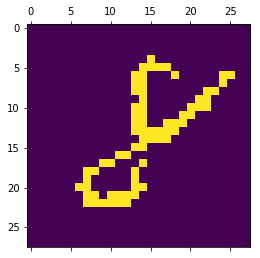

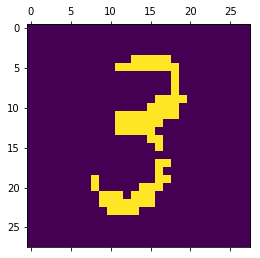

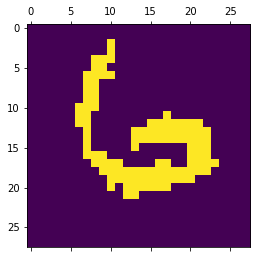

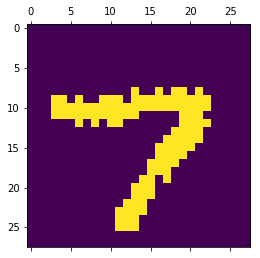

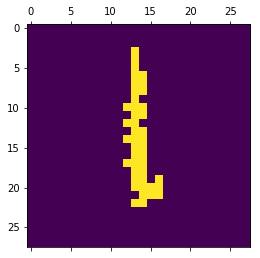

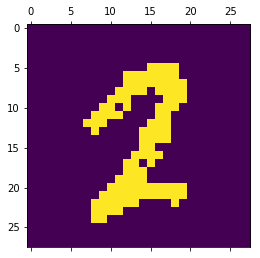

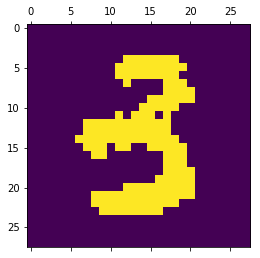

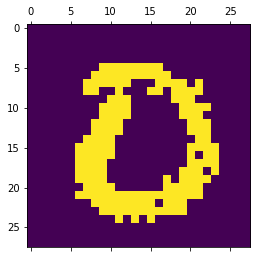

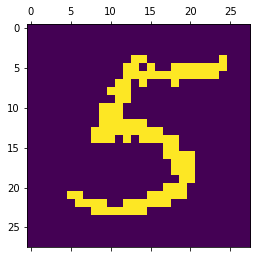

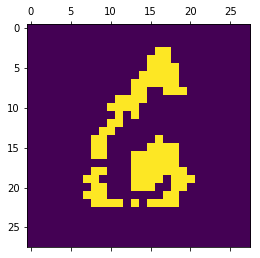

In [5]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

In [6]:
batchsize = 50

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [7]:
for batch_idx, d in enumerate(train_loader_labeled):
    labeled_data = d
    break
    
for batch_idx, d in enumerate(train_loader_unlabeled):
    unlabeled_data = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


# Define VAE

In [8]:
latent_dim = 8
n_classes = 10
slen = train_set_unlabeled[0]['image'].shape[0]

In [9]:
vae, classifier = mnist_vae_lib.get_mnist_vae_and_classifier(latent_dim = latent_dim, 
                                                                n_classes = n_classes, 
                                                               slen = slen)

In [10]:
# Load results

file_base = './mnist_vae_results/warm_starts'
classifier_file = file_base + 'classifier_final'
vae_file = file_base + 'vae_final'

vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))

classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

MNISTConditionalVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=18, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)

# Check losses

In [11]:
batch_losses = np.load(file_base + '_batch_losses.npy')

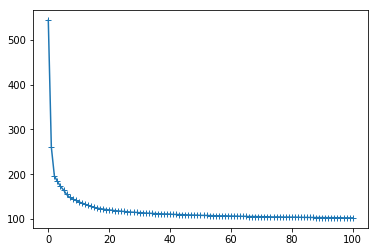

In [12]:
# plot losses
plt.plot(batch_losses, '+-')

In [13]:
train_losses = np.load(file_base + '_train_losses.npy')
test_losses = np.load(file_base + '_test_losses.npy')

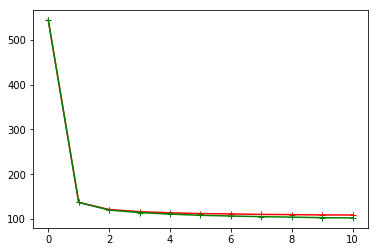

In [14]:
plt.plot(test_losses, 'r-+')
plt.plot(train_losses, 'g-+')

In [15]:
train_accuracies = np.load(file_base + '_train_accuracy.npy')
test_accuracies = np.load(file_base + '_test_accuracy.npy')

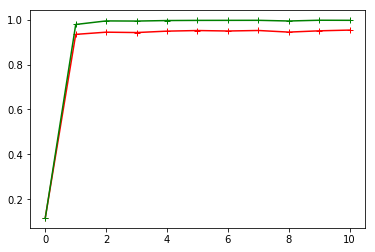

In [16]:
plt.plot(test_accuracies, 'r-+')
plt.plot(train_accuracies, 'g-+')

In [17]:
image = labeled_data['image']
log_q = classifier(image)
z = torch.argmax(log_q, dim = 1)

In [18]:
loss = vae_utils.get_labeled_loss(vae, image, z).mean()

In [19]:
loss

tensor(103.7020)

In [20]:
batch_losses[-1]

102.66866

# Check reconstructions

In [21]:
latent_means, latent_std, latent_samples, image_mean = \
    vae.forward(image, z)

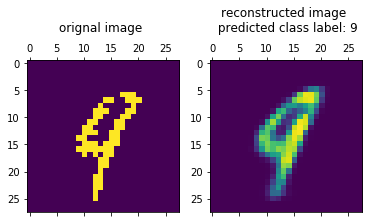

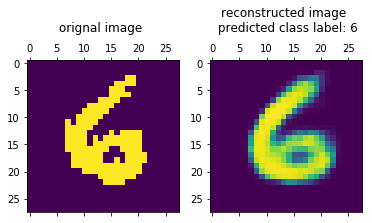

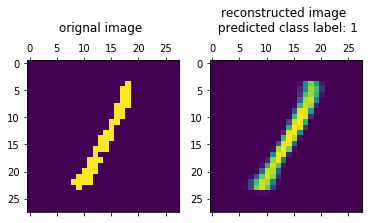

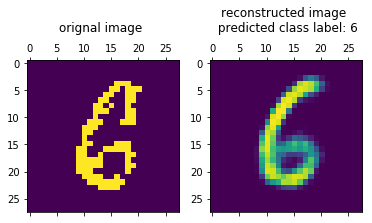

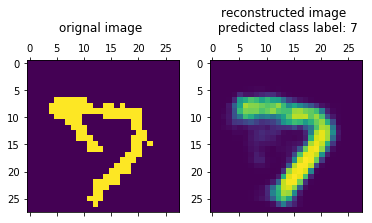

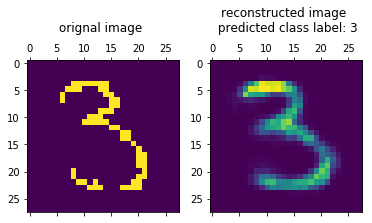

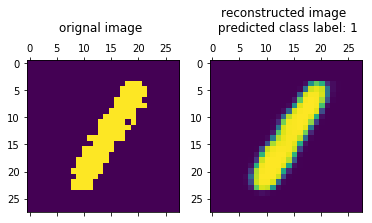

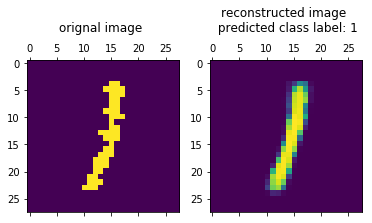

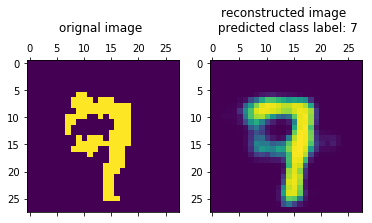

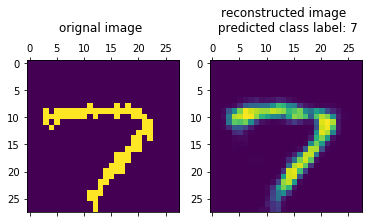

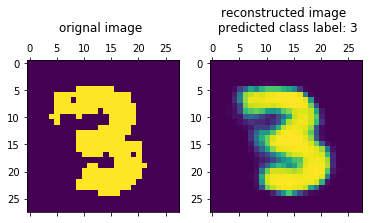

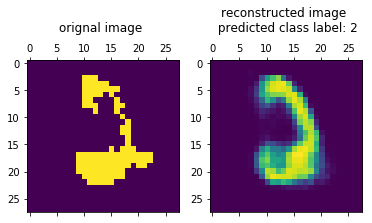

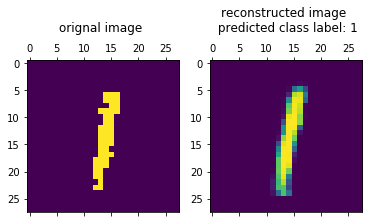

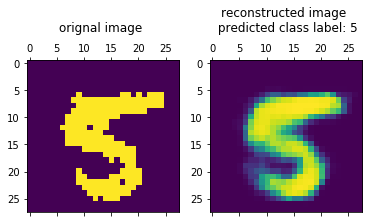

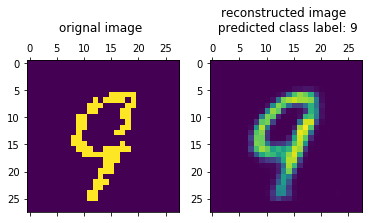

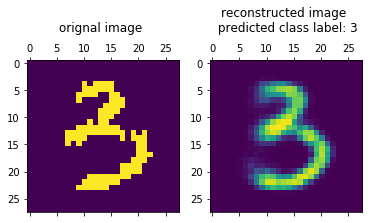

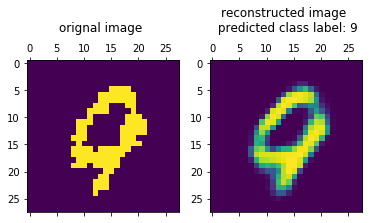

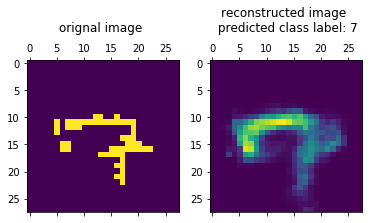

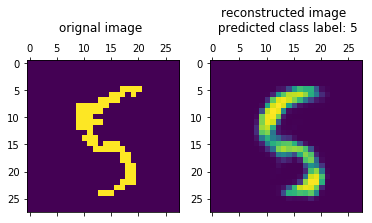

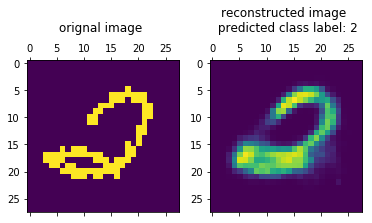

In [22]:
figsize = 6
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(image[i, :, :])
    axarr[1].matshow(image_mean[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n')
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z[i]))

# check conditional generation

In [ ]:
for i in range(10): 
    num = 10
    latent_params = torch.randn((10, latent_dim)) 

    digit = i
    one_hot_z = vae_utils.get_one_hot_encoding_from_int(torch.ones(num) * digit, n_classes)
    recon_mean = vae.decoder(latent_params, one_hot_z)

    f, axarr = plt.subplots(1, num, figsize=(15, 15))

    for i in range(0, num): 
        axarr[i].matshow(recon_mean[i, :, :].detach())
